In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union

import logging
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import xarray

from tqdm import tqdm

LOGGER = logging.getLogger(__name__)

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
x_d_1H_array = torch.tensor(np.load("x_d_1H_array.npy"))
x_d_1D_array = torch.tensor(np.load("x_d_1D_array.npy"))
y_1H_array = torch.tensor(np.load("y_1H_array.npy"))
y_1D_array = torch.tensor(np.load("y_1D_array.npy"))

In [4]:
print(x_d_1H_array.shape, x_d_1H_array.dtype)
print(x_d_1D_array.shape, x_d_1D_array.dtype)

print(y_1H_array.shape, y_1H_array.dtype)
print(y_1D_array.shape, y_1D_array.dtype)


torch.Size([87648, 16]) torch.float32
torch.Size([3652, 5]) torch.float32
torch.Size([87648, 1]) torch.float32
torch.Size([3652, 1]) torch.float32


In [5]:
array_list = [x_d_1H_array, y_1H_array, x_d_1D_array,  y_1D_array]
key_list = ['in_highres', 'out_highres', 'in_lowres', 'out_lowres']

In [6]:
data_dict = dict(zip(key_list,array_list))

In [7]:
hr_slen = 336
lr_slen = 365


In [8]:
H_lookup = np.load("H_lookup.npy")
D_lookup = np.load("D_lookup.npy")


In [9]:
H_lookup

array([ 8759,  8783,  8807, ..., 87599, 87623, 87647])

In [10]:
np.arange(364, 3652)

array([ 364,  365,  366, ..., 3649, 3650, 3651])

In [11]:
3651*24

87624

In [12]:
D_lookup.dtype

dtype('int64')

In [13]:
data_dict['in_highres'][8759 - 336 + 1: 8759+1].shape

torch.Size([336, 16])

In [32]:
f'x_d_1H'

'x_d_1H'

Load validation and test data (rainfall)

In [35]:
x_d_1H_array_val = torch.tensor(np.load("x_d_1H_array_val.npy"))
x_d_1D_array_val = torch.tensor(np.load("x_d_1D_array_val.npy"))
y_1H_array_val = torch.tensor(np.load("y_1H_array_val.npy"))
y_1D_array_val = torch.tensor(np.load("y_1D_array_val.npy"))

H_lookup_val = np.load("H_lookup_val.npy")
D_lookup_val = np.load("D_lookup_val.npy")


data_dict_val = dict(zip(key_list,[x_d_1H_array_val, y_1H_array_val, x_d_1D_array_val,  y_1D_array_val]))



In [36]:
data_dict_val

{'in_highres': tensor([[-0.2065, -0.0408, -0.2343,  ...,  0.8076,  0.5197,  0.3650],
         [-0.2065, -0.0409, -0.2343,  ...,  0.8076,  0.5197,  0.3650],
         [-0.2065, -0.0409, -0.2343,  ...,  0.8076,  0.5197,  0.3650],
         ...,
         [ 7.9878,  1.3757, -0.1260,  ...,  0.7227,  1.0108,  1.0089],
         [ 0.2825,  1.3756, -0.1619,  ...,  0.7227,  1.0108,  1.0089],
         [-0.2065,  1.3756, -0.1982,  ...,  0.7227,  1.0108,  1.0089]]),
 'out_highres': tensor([[    nan],
         [    nan],
         [    nan],
         ...,
         [-0.4820],
         [-0.4809],
         [-0.4780]]),
 'in_lowres': tensor([[-0.5128,  0.2444,  0.8076,  0.5197,  0.3650],
         [ 0.1786, -0.7620,  0.6196,  0.6479,  0.5313],
         [ 0.1345, -1.6310,  0.2321,  0.6795,  0.5259],
         ...,
         [-0.5349,  0.4120,  0.8449,  0.5661,  0.6113],
         [-0.5317, -0.5012,  0.8048,  0.9862,  1.1195],
         [-0.1837, -0.8999,  0.7227,  1.0108,  1.0089]]),
 'out_lowres': tensor([[    

In [42]:

class TemporalDS(Dataset):
    def __init__(self, data_dict, hr_seq_len, lr_seq_len, hlkup, dlkup):
        self.datadict = data_dict
        self.hr_seq_len = hr_seq_len
        self.lr_seq_len = lr_seq_len
        self.freq_factor = 24.0
        self.hlookup = hlkup
        self.dlookup = dlkup
        self.num_samples = self.hlookup.shape[0] #hardcoded right now for this example DS
        
        
    def __getitem__(self, index)-> Dict[str, torch.Tensor]:
        hr_idx = self.hlookup[index]
        lr_idx = self.dlookup[index]
        
        
        sample = {}
        
        #populate for high res first (i.e. hourly)
        sample[f'x_d_1H'] = self.datadict['in_highres'][hr_idx - self.hr_seq_len + 1: hr_idx+1]
        sample[f'y_1H'] = self.datadict['out_highres'][hr_idx - self.hr_seq_len + 1: hr_idx+1]
        
        sample[f'x_d_1D'] = self.datadict['in_lowres'][lr_idx - self.lr_seq_len + 1: lr_idx+1]
        sample[f'y_1D'] = self.datadict['out_lowres'][lr_idx - self.lr_seq_len + 1: lr_idx+1]

        return sample

    def __len__(self):
        return self.num_samples

In [44]:
t_ds = TemporalDS(data_dict, hr_seq_len=336, lr_seq_len=365, hlkup=H_lookup, dlkup=D_lookup)

In [45]:
len(t_ds)

2739

In [46]:
t_dl = DataLoader(t_ds, batch_size=256, shuffle=True)

In [47]:
for d in t_dl:
    print(d['x_d_1H'].shape)

torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([179, 336, 16])


In [48]:
t_ds_val = TemporalDS(data_dict_val, hr_seq_len=336, lr_seq_len=365, hlkup=H_lookup_val, dlkup=D_lookup_val)

In [49]:
len(t_ds_val)

1095

In [64]:
t_dl_val = DataLoader(t_ds_val, batch_size=256, shuffle=False, num_workers=0)

In [65]:
for d in t_dl_val:
    print(d['x_d_1H'].shape)

torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([256, 336, 16])
torch.Size([71, 336, 16])


Custom dataset and dataloader in partially done at this point

Now, create model and train. Will have to use neuralhydrology lib

In [118]:
from neuralhydrology.utils.config import Config
from neuralhydrology.utils.samplingutils import sample_pointpredictions
from neuralhydrology.datautils.utils import get_frequency_factor, sort_frequencies
from neuralhydrology.modelzoo.head import get_head

import neuralhydrology.training.loss as loss


In [51]:
class BaseModel(nn.Module):
    
    # specify submodules of the model that can later be used for finetuning. Names must match class attributes
    module_parts = []

    def __init__(self, cfg: Config):
        super(BaseModel, self).__init__()
        self.cfg = cfg
        self.output_size = len(cfg.target_variables)
        # if cfg.head.lower() == 'gmm':
        #     self.output_size *= 3 * cfg.n_distributions
        # elif cfg.head.lower() == 'cmal':
        #     self.output_size *= 4 * cfg.n_distributions
        # elif cfg.head.lower() == 'umal':
        #     self.output_size *= 2

    def sample(self, data: Dict[str, torch.Tensor], n_samples: int) -> Dict[str, torch.Tensor]:
        
        return sample_pointpredictions(self, data, n_samples)

    def forward(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        
        raise NotImplementedError

In [52]:
class MTSLSTM(BaseModel):
    
    # specify submodules of the model that can later be used for finetuning. Names must match class attributes
    module_parts = ['lstms', 'transfer_fcs', 'heads']

    def __init__(self, cfg: Config):
        super(MTSLSTM, self).__init__(cfg=cfg)
        self.lstms = None
        self.transfer_fcs = None
        self.heads = None
        self.dropout = None

        self._slice_timestep = {}
        self._frequency_factors = []

        self._seq_lengths = cfg.seq_length
        self._is_shared_mtslstm = self.cfg.shared_mtslstm  # default: a distinct LSTM per timescale
        self._transfer_mtslstm_states = self.cfg.transfer_mtslstm_states  # default: linear transfer layer
        transfer_modes = [None, "None", "identity", "linear"]
        if self._transfer_mtslstm_states["h"] not in transfer_modes \
                or self._transfer_mtslstm_states["c"] not in transfer_modes:
            raise ValueError(f"MTS-LSTM supports state transfer modes {transfer_modes}")

        if len(cfg.use_frequencies) < 2:
            raise ValueError("MTS-LSTM expects more than one input frequency")
        self._frequencies = sort_frequencies(cfg.use_frequencies)

        # start to count the number of inputs
        input_sizes = len(cfg.static_attributes + cfg.hydroatlas_attributes + cfg.evolving_attributes)

        # if is_shared_mtslstm, the LSTM gets an additional frequency flag as input.
        if self._is_shared_mtslstm:
            input_sizes += len(self._frequencies)

        if cfg.use_basin_id_encoding:
            input_sizes += cfg.number_of_basins
        if cfg.head.lower() == "umal":
            input_sizes += 1

        if isinstance(cfg.dynamic_inputs, list):
            input_sizes = {freq: input_sizes + len(cfg.dynamic_inputs) for freq in self._frequencies}
        else:
            if self._is_shared_mtslstm:
                raise ValueError(f'Different inputs not allowed if shared_mtslstm is used.')
            input_sizes = {freq: input_sizes + len(cfg.dynamic_inputs[freq]) for freq in self._frequencies}

        if not isinstance(cfg.hidden_size, dict):
            LOGGER.info("No specific hidden size for frequencies are specified. Same hidden size is used for all.")
            self._hidden_size = {freq: cfg.hidden_size for freq in self._frequencies}
        else:
            self._hidden_size = cfg.hidden_size

        if (self._is_shared_mtslstm
            or self._transfer_mtslstm_states["h"] == "identity"
            or self._transfer_mtslstm_states["c"] == "identity") \
                and any(size != self._hidden_size[self._frequencies[0]] for size in self._hidden_size.values()):
            raise ValueError("All hidden sizes must be equal if shared_mtslstm is used or state transfer=identity.")

        # create layer depending on selected frequencies
        self._init_modules(input_sizes)
        self._reset_parameters()

        # frequency factors are needed to determine the time step of information transfer
        self._init_frequency_factors_and_slice_timesteps()

    def _init_modules(self, input_sizes: Dict[str, int]):
        self.lstms = nn.ModuleDict()
        self.transfer_fcs = nn.ModuleDict()
        self.heads = nn.ModuleDict()
        self.dropout = nn.Dropout(p=self.cfg.output_dropout)
        for idx, freq in enumerate(self._frequencies):
            freq_input_size = input_sizes[freq]

            if self._is_shared_mtslstm and idx > 0:
                self.lstms[freq] = self.lstms[self._frequencies[idx - 1]]  # same LSTM for all frequencies.
                self.heads[freq] = self.heads[self._frequencies[idx - 1]]  # same head for all frequencies.
            else:
                self.lstms[freq] = nn.LSTM(input_size=freq_input_size, hidden_size=self._hidden_size[freq])
                self.heads[freq] = get_head(self.cfg, n_in=self._hidden_size[freq], n_out=self.output_size)

            if idx < len(self._frequencies) - 1:
                for state in ["c", "h"]:
                    if self._transfer_mtslstm_states[state] == "linear":
                        self.transfer_fcs[f"{state}_{freq}"] = nn.Linear(self._hidden_size[freq],
                                                                         self._hidden_size[self._frequencies[idx + 1]])
                    elif self._transfer_mtslstm_states[state] == "identity":
                        self.transfer_fcs[f"{state}_{freq}"] = nn.Identity()
                    else:
                        pass

    def _init_frequency_factors_and_slice_timesteps(self):
        for idx, freq in enumerate(self._frequencies):
            if idx < len(self._frequencies) - 1:
                frequency_factor = get_frequency_factor(freq, self._frequencies[idx + 1])
                if frequency_factor != int(frequency_factor):
                    raise ValueError('Adjacent frequencies must be multiples of each other.')
                self._frequency_factors.append(int(frequency_factor))
                # we want to pass the state of the day _before_ the next higher frequency starts,
                # because e.g. the mean of a day is stored at the same date at 00:00 in the morning.
                slice_timestep = int(self._seq_lengths[self._frequencies[idx + 1]] / self._frequency_factors[idx])
                self._slice_timestep[freq] = slice_timestep

    def _reset_parameters(self):
        if self.cfg.initial_forget_bias is not None:
            for freq in self._frequencies:
                hidden_size = self._hidden_size[freq]
                self.lstms[freq].bias_hh_l0.data[hidden_size:2 * hidden_size] = self.cfg.initial_forget_bias

    def _prepare_inputs(self, data: Dict[str, torch.Tensor], freq: str) -> torch.Tensor:
        """Concat all different inputs to the time series input"""
        suffix = f"_{freq}"
        # transpose to [seq_length, batch_size, n_features]
        x_d = data[f'x_d{suffix}'].transpose(0, 1)

        # concat all inputs
        if f'x_s{suffix}' in data and 'x_one_hot' in data:
            x_s = data[f'x_s{suffix}'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_one_hot = data['x_one_hot'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_d = torch.cat([x_d, x_s, x_one_hot], dim=-1)
        elif f'x_s{suffix}' in data:
            x_s = data[f'x_s{suffix}'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_d = torch.cat([x_d, x_s], dim=-1)
        elif 'x_one_hot' in data:
            x_one_hot = data['x_one_hot'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_d = torch.cat([x_d, x_one_hot], dim=-1)
        else:
            pass

        if self._is_shared_mtslstm:
            # add frequency one-hot encoding
            idx = self._frequencies.index(freq)
            one_hot_freq = torch.zeros(x_d.shape[0], x_d.shape[1], len(self._frequencies)).to(x_d)
            one_hot_freq[:, :, idx] = 1
            x_d = torch.cat([x_d, one_hot_freq], dim=2)

        return x_d

    def forward(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Perform a forward pass on the MTS-LSTM model.
        
        Parameters
        ----------
        data : Dict[str, torch.Tensor]
            Input data for the forward pass. See the documentation overview of all models for details on the dict keys.
        Returns
        -------
        Dict[str, torch.Tensor]
            Model predictions for each target timescale.
        """
        x_d = {freq: self._prepare_inputs(data, freq) for freq in self._frequencies}

        # initial states for lowest frequencies are set to zeros
        batch_size = x_d[self._frequencies[0]].shape[1]
        lowest_freq_hidden_size = self._hidden_size[self._frequencies[0]]
        h_0_transfer = x_d[self._frequencies[0]].new_zeros((1, batch_size, lowest_freq_hidden_size))
        c_0_transfer = torch.zeros_like(h_0_transfer)

        outputs = {}
        for idx, freq in enumerate(self._frequencies):
            if idx < len(self._frequencies) - 1:
                # get predictions and state up to the time step of information transfer
                slice_timestep = self._slice_timestep[freq]
                lstm_output_slice1, (h_n_slice1, c_n_slice1) = self.lstms[freq](x_d[freq][:-slice_timestep],
                                                                                (h_0_transfer, c_0_transfer))

                # project the states through a hidden layer to the dimensions of the next LSTM
                if self._transfer_mtslstm_states["h"] is not None:
                    h_0_transfer = self.transfer_fcs[f"h_{freq}"](h_n_slice1)
                if self._transfer_mtslstm_states["c"] is not None:
                    c_0_transfer = self.transfer_fcs[f"c_{freq}"](c_n_slice1)

                # get predictions of remaining part and concat results
                lstm_output_slice2, _ = self.lstms[freq](x_d[freq][-slice_timestep:], (h_n_slice1, c_n_slice1))
                lstm_output = torch.cat([lstm_output_slice1, lstm_output_slice2], dim=0)

            else:
                # for highest frequency, we can pass the entire sequence at once
                lstm_output, _ = self.lstms[freq](x_d[freq], (h_0_transfer, c_0_transfer))

            head_out = self.heads[freq](self.dropout(lstm_output.transpose(0, 1)))
            outputs.update({f'{key}_{freq}': value for key, value in head_out.items()})

        return outputs

In [111]:
def _get_predictions_and_loss(model, data, l_obj):
    predictions = model(data)
    loss = l_obj(predictions, data)
    return predictions, loss.item()

def _subset_targets(data, predictions, predict_last_n, freq):
    y_hat_sub = predictions[f'y_hat{freq}'][:, -predict_last_n:, :]
    y_sub = data[f'y{freq}'][:, -predict_last_n:, :]
    return y_hat_sub, y_sub


def _evaluate(model, loader, l_obj, frequencies):
    """Evaluate model"""
    predict_last_n = conf_obj.predict_last_n
    # if isinstance(predict_last_n, int):
    #     predict_last_n = {frequencies[0]: predict_last_n}  # if predict_last_n is int, there's only one frequency

    preds, obs = {}, {}
    losses = []
    with torch.no_grad():
        for data in loader:

            # for key in data:
            #     data[key] = data[key].to(self.device)
            predictions, loss = _get_predictions_and_loss(model, data, l_obj)

            for freq in frequencies:
                freq_key = f'_{freq}'
                y_hat_sub, y_sub = _subset_targets(data, predictions, predict_last_n[freq], freq_key)

                if freq not in preds:
                    preds[freq] = y_hat_sub.detach().cpu()
                    obs[freq] = y_sub.cpu()
                else:
                    preds[freq] = torch.cat((preds[freq], y_hat_sub.detach().cpu()), 0)
                    obs[freq] = torch.cat((obs[freq], y_sub.detach().cpu()), 0)

            losses.append(loss)

        for freq in preds.keys():
            preds[freq] = preds[freq].numpy()
            obs[freq] = obs[freq].numpy()

    # set to NaN explicitly if all losses are NaN to avoid RuntimeWarning
    mean_loss = np.nanmean(losses) if len(losses) > 0 and not all(np.isnan(l) for l in losses) else np.nan
    return preds, obs, mean_loss

In [53]:
mymodel._is_shared_mtslstm

False

In [142]:
mymodel._frequencies

['1D', '1H']

In [54]:
conf_obj = Config(Path('1_basin.yml'))

In [146]:
conf_obj.dynamic_inputs

{'1D': ['prcp(mm/day)_maurer_extended',
  'srad(W/m2)_maurer_extended',
  'tmax(C)_maurer_extended',
  'tmin(C)_maurer_extended',
  'vp(Pa)_maurer_extended'],
 '1H': ['convective_fraction_nldas_hourly',
  'longwave_radiation_nldas_hourly',
  'potential_energy_nldas_hourly',
  'potential_evaporation_nldas_hourly',
  'pressure_nldas_hourly',
  'shortwave_radiation_nldas_hourly',
  'specific_humidity_nldas_hourly',
  'temperature_nldas_hourly',
  'total_precipitation_nldas_hourly',
  'wind_u_nldas_hourly',
  'wind_v_nldas_hourly',
  'prcp(mm/day)_maurer_extended',
  'srad(W/m2)_maurer_extended',
  'tmax(C)_maurer_extended',
  'tmin(C)_maurer_extended',
  'vp(Pa)_maurer_extended']}

In [150]:
isinstance(conf_obj.dynamic_inputs['1H'], list)

True

In [156]:
mymodel._frequency_factors


[24]

In [151]:
{freq: 0 + len(conf_obj.dynamic_inputs) for freq in mymodel._frequencies}

{'1D': 2, '1H': 2}

In [124]:
mymodel = MTSLSTM(conf_obj)

In [157]:
mymodel._is_shared_mtslstm

False

In [125]:
mymodel

MTSLSTM(
  (lstms): ModuleDict(
    (1D): LSTM(5, 20)
    (1H): LSTM(16, 20)
  )
  (transfer_fcs): ModuleDict(
    (c_1D): Linear(in_features=20, out_features=20, bias=True)
    (h_1D): Linear(in_features=20, out_features=20, bias=True)
  )
  (heads): ModuleDict(
    (1D): Regression(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (1H): Regression(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=1, bias=True)
      )
    )
  )
  (dropout): Dropout(p=0.4, inplace=False)
)

In [126]:
conf_obj.predict_last_n

{'1D': 1, '1H': 24}

In [127]:
optimizer = torch.optim.Adam(mymodel.parameters(), lr=1e-2)

In [128]:
loss_obj = loss.MaskedMSELoss(conf_obj)

In [129]:
loss_obj

MaskedMSELoss()

In [160]:
loss_obj._target_weights

tensor([1.])

In [164]:
conf_obj.target_loss_weights

In [130]:
conf_obj.mc_dropout

False

In [161]:
tt = [1.0]

In [162]:
torch.tensor(tt)

tensor([1.])

In [137]:
for epoch in range(50):
    mymodel.train()
    pbar = tqdm(t_dl)
    
    for data in pbar:
        predictions = mymodel(data)
        loss_val = loss_obj(predictions, data)
        optimizer.zero_grad()
        loss_val.backward()
        
        torch.nn.utils.clip_grad_norm_(mymodel.parameters(), 1)
        optimizer.step()
        
        pbar.set_postfix_str(f"Loss: {loss_val.item():.4f}")
    
    if epoch%5 == 0:    
        ## validate
        mymodel.eval()
        _, _, avg_val_loss = _evaluate(mymodel, t_dl_val, loss_obj, conf_obj.use_frequencies)
        print("Avg. validation loss", avg_val_loss)
        
        
        
        
        
        
        
        
    
    

100%|██████████| 11/11 [00:03<00:00,  2.83it/s, Loss: 0.0751]


Avg. validation loss 0.21961527168750763


100%|██████████| 11/11 [00:03<00:00,  2.79it/s, Loss: 0.0670]


Avg. validation loss 0.2222240149974823


100%|██████████| 11/11 [00:03<00:00,  2.86it/s, Loss: 0.1262]


Avg. validation loss 0.22537840902805328


100%|██████████| 11/11 [00:03<00:00,  2.84it/s, Loss: 0.0753]


Avg. validation loss 0.19415228068828583


100%|██████████| 11/11 [00:03<00:00,  2.84it/s, Loss: 0.0656]


Avg. validation loss 0.22728019654750825


100%|██████████| 11/11 [00:03<00:00,  2.86it/s, Loss: 0.0558]


Avg. validation loss 0.2216474086046219


100%|██████████| 11/11 [00:03<00:00,  2.87it/s, Loss: 0.0719]


Avg. validation loss 0.2123498350381851


100%|██████████| 11/11 [00:03<00:00,  2.82it/s, Loss: 0.0828]


Avg. validation loss 0.20367392152547836


100%|██████████| 11/11 [00:03<00:00,  2.85it/s, Loss: 0.0640]


Avg. validation loss 0.22627511620521545


100%|██████████| 11/11 [00:03<00:00,  2.88it/s, Loss: 0.0553]


Avg. validation loss 0.21722330451011657


100%|██████████| 11/11 [00:03<00:00,  2.82it/s, Loss: 0.0449]


In [136]:
ll_val = []
for d in t_dl_val:
    mymodel.eval()
    pred, l = _get_predictions_and_loss(mymodel, d, loss_obj)
    print(l)
    ll_val.append(l)
    
print("avg loss:", np.mean(ll_val))

0.1406838446855545
0.23654897511005402
0.31690919399261475
0.18032002449035645
0.1600254774093628
avg loss: 0.2068975031375885


In [88]:
pred.keys()

dict_keys(['y_hat_1D', 'y_hat_1H'])

In [93]:
p1, o1, mean_l1 = _evaluate(mymodel, t_dl_val, loss_obj, conf_obj.use_frequencies)

In [94]:
mean_l1

0.17049912214279175

In [109]:
o1['1H'][:,:,0].shape

(1095, 24)

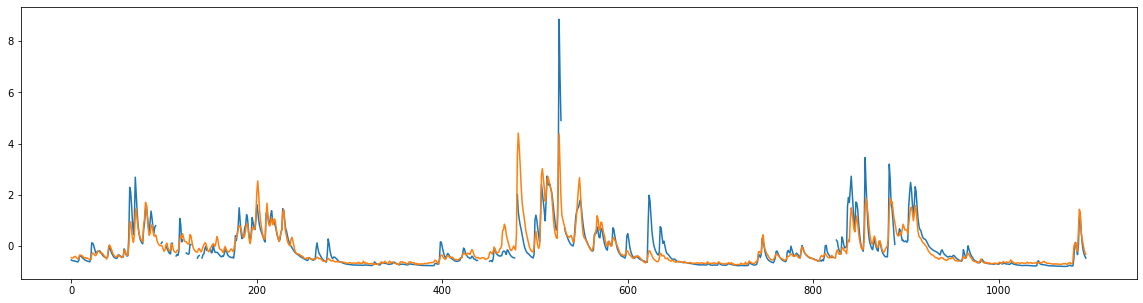

In [107]:
plt.figure(figsize=(20,5))
plt.plot(o1['1D'][:,0,0])
plt.plot(p1['1D'][:,0,0])
plt.show()

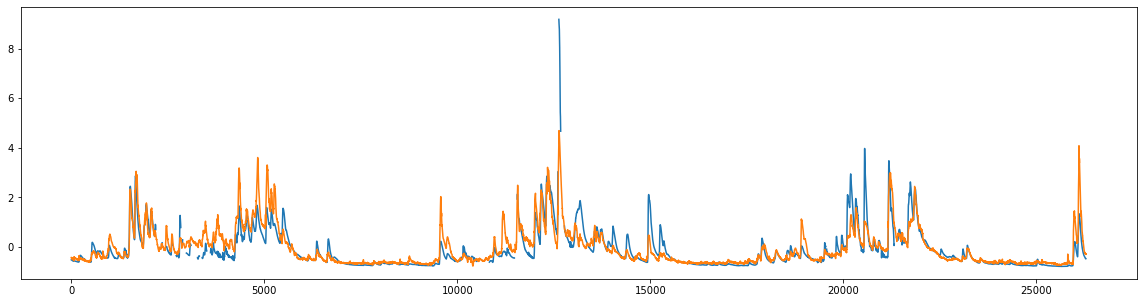

In [110]:
plt.figure(figsize=(20,5))
plt.plot(o1['1H'][:,:,0].flatten())
plt.plot(p1['1H'][:,:,0].flatten())
plt.show()

In [69]:
conf_obj.predict_last_n['1H']

24

In [70]:
conf_obj.use_frequencies

['1H', '1D']

In [119]:
dd1 = next(iter(t_dl))  

In [120]:
pred = mymodel(dd1)

In [121]:
loss_obj(pred, dd1)

tensor(0.0745, grad_fn=<SumBackward0>)

In [122]:
pred['y_hat_1H'].shape

torch.Size([256, 336, 1])

In [123]:
pred['y_hat_1D'].shape

torch.Size([256, 365, 1])

In [124]:
t_ds[1000]

{'x_d_1H': tensor([[-0.2065, -0.8359, -0.2343,  ..., -0.2920, -0.5966, -0.6735],
         [-0.2065, -0.8360, -0.2343,  ..., -0.2920, -0.5966, -0.6735],
         [-0.2065, -0.8360, -0.2343,  ..., -0.2920, -0.5966, -0.6735],
         ...,
         [-0.2065,  0.0515, -0.2343,  ..., -0.3254, -0.0049, -0.3113],
         [-0.2065,  0.0515, -0.2343,  ..., -0.3254, -0.0049, -0.3113],
         [-0.2065,  0.0514, -0.2343,  ..., -0.3254, -0.0049, -0.3113]]),
 'y_1H': tensor([[1.1504],
         [1.1395],
         [1.1359],
         [1.1214],
         [1.1214],
         [1.1250],
         [1.1033],
         [1.0924],
         [1.0888],
         [1.0743],
         [1.0670],
         [1.0670],
         [1.0489],
         [1.0381],
         [1.0344],
         [1.0199],
         [1.0091],
         [0.9909],
         [0.9909],
         [0.9801],
         [0.9656],
         [0.9656],
         [0.9511],
         [0.9402],
         [0.9438],
         [0.9257],
         [0.9257],
         [0.9112],
        

In [125]:
dd1.keys()

dict_keys(['x_d_1H', 'y_1H', 'x_d_1D', 'y_1D'])

In [126]:
t_ds[1000]['x_d_1H'].shape

torch.Size([336, 16])

In [127]:
new_dl = DataLoader(t_ds, batch_size=1, shuffle=False)

In [128]:
len(new_dl)

2739

In [129]:
new_dl_instances = []
c = 0
for d in new_dl:
    if c == 200:
        new_dl_instances.append(d)
    c += 1
    

In [130]:
new_dl_instances[0]['x_d_1H'].shape

torch.Size([1, 336, 16])

In [131]:
new_pred_1 = mymodel(new_dl_instances[0])

In [132]:
print(new_pred_1['y_hat_1D'].shape)
print(new_pred_1['y_hat_1H'].shape)


torch.Size([1, 365, 1])
torch.Size([1, 336, 1])


In [133]:
loss_obj(new_pred_1, new_dl_instances[0])

tensor(0.0071, grad_fn=<SumBackward0>)

In [134]:
new_pred_24h = new_pred_1['y_hat_1H'][0,-24:]

In [135]:
new_pred_24h[:,0].detach().numpy()

array([-0.27909568, -0.20366031, -0.36688223, -0.29269677, -0.23723349,
       -0.28814092, -0.41222063, -0.16816851, -0.38252708, -0.29071572,
       -0.35250932, -0.16406035, -0.30993822, -0.19621018, -0.16983306,
       -0.18326929, -0.35739467, -0.13446903, -0.30246398, -0.26967147,
       -0.18143278, -0.19726369, -0.30271497, -0.24550736], dtype=float32)

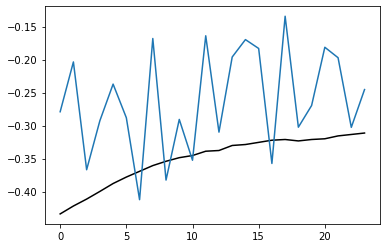

In [136]:
plt.plot(new_dl_instances[0]['y_1H'][0,-24:], c='k')
plt.plot(new_pred_24h[:,0].detach().numpy())